In [2]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import mne
from mne.preprocessing import ICA
import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram

Preproccesing Functions

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    # df_new = z_score(df_new, col_names)
    # df_new = custom_detrend(df_new, col_names)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.1 times smaller
    # Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    df[channel] = interpolated_values
    return df


Define the dataset

In [4]:
import os
import numpy as np
import pandas as pd
import mne
from mne.preprocessing import ICA
from mne.viz import plot_topomap
from scipy.signal import welch
import numpy as np


import matplotlib.pyplot as plt

In [5]:
montage = mne.channels.make_standard_montage('standard_1020')

Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.


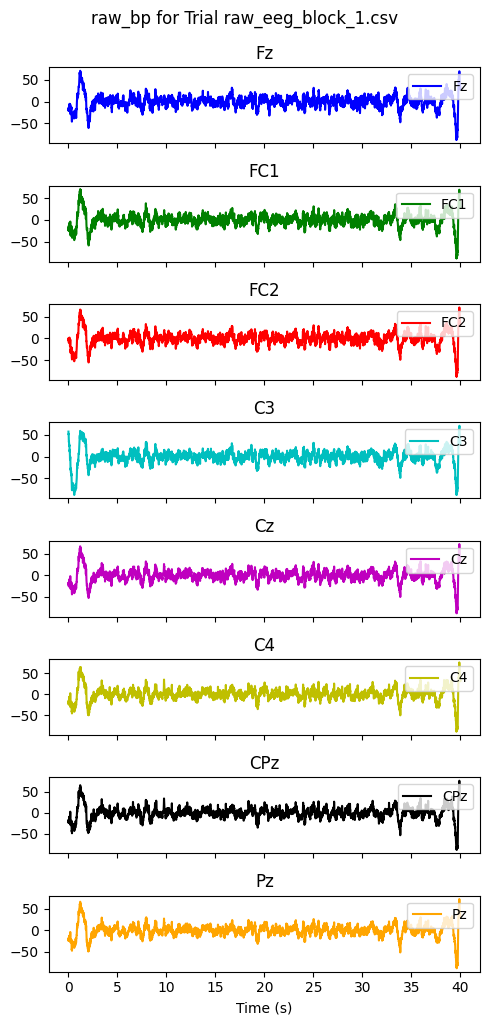

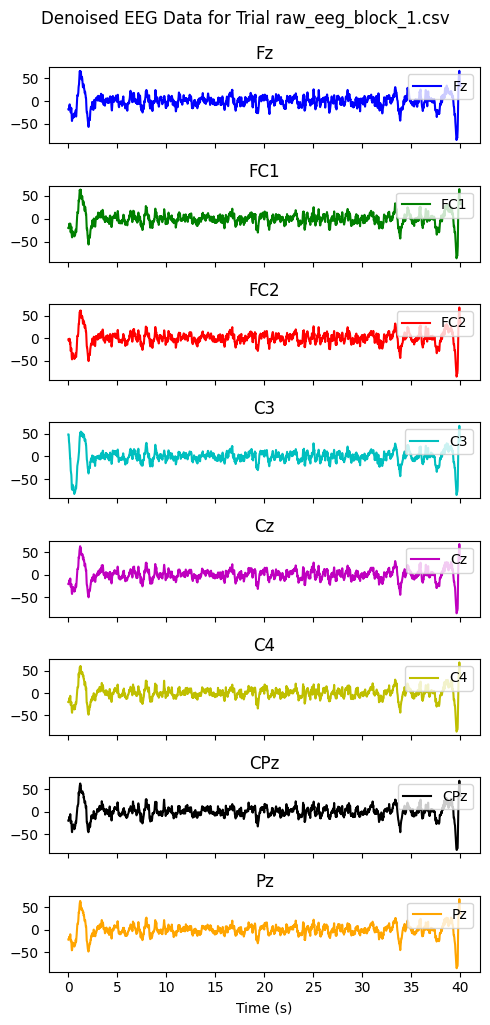

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Computing Extended Infomax ICA


C:\Users\tnlab\AppData\Local\Temp\ipykernel_23664\318554371.py:69: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne, picks='eeg')


Fitting ICA took 0.9s.


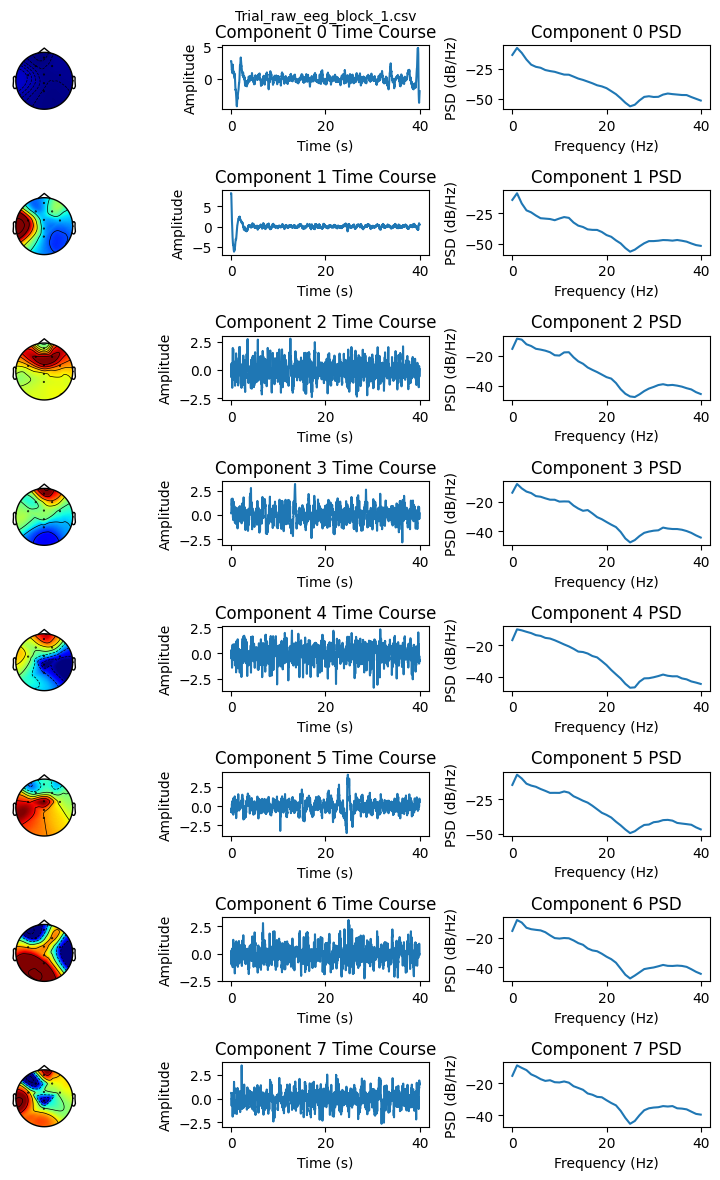

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 3 ICA components
    Projecting back using 8 PCA components


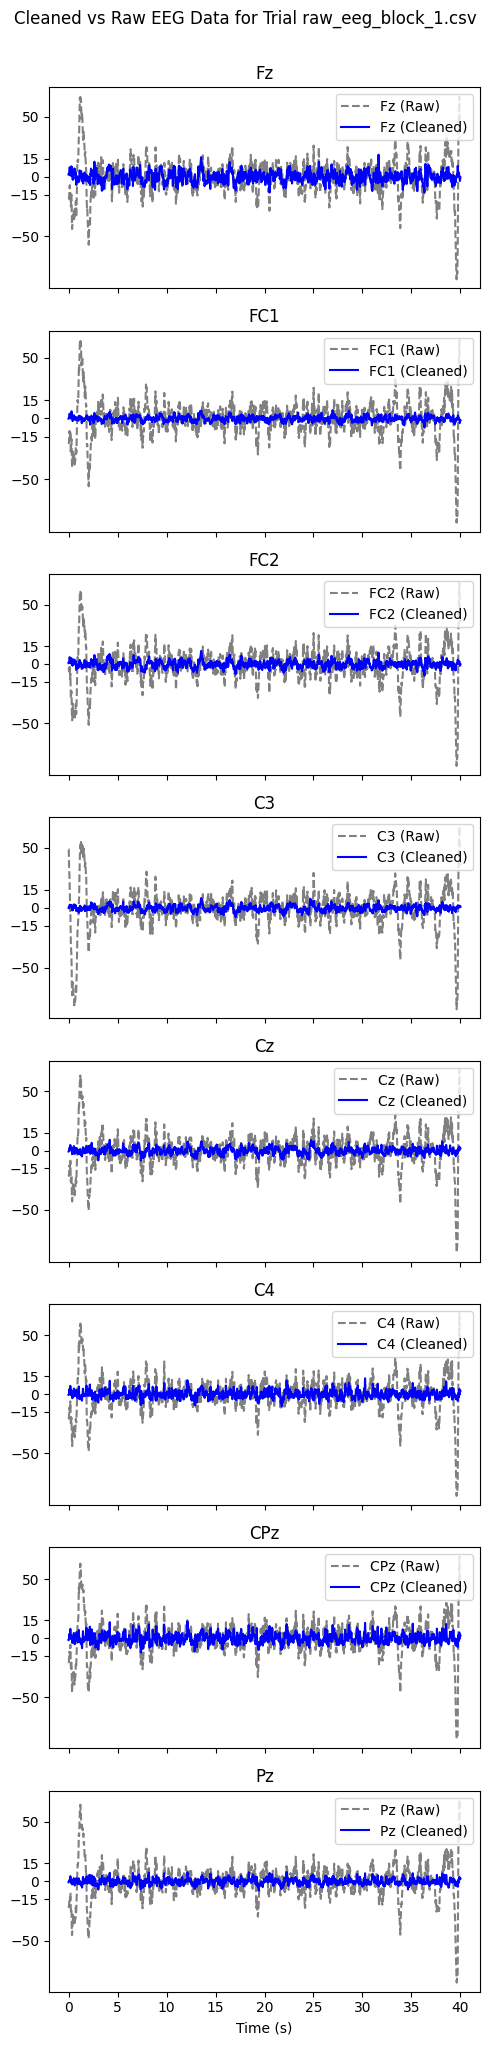

In [25]:
folder_name = 'i'
selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
# Define a list of colors, can be extended or modified
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray']
duration = 40 
raw=[]
event=[]
PP=[]
BP=[]
cleaned_data_list = []
cleaned_smothed_list = []
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst = s_temp.iloc[:, 17]
            df_temp = s_temp.iloc[:, :8]
            # print(df_temp.shape)
            # df_temp.plot(figsize=(10, 8))
            # plt.show()
            raw.append(df_temp)
            event.append(inst)
            
            # 1. Band Pass
            raw_bp = np.copy(df_temp)
            for column in range(8):
                raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
            # plt.plot(raw_bp)
            # plt.show()
            
            
            # Denoise the cleaned data
            raw_bp_df = pd.DataFrame(raw_bp, columns=selected_columns)
            n_clusters = [10]*len(selected_columns)  # adjust the values based on how much smoothing you want
            denoised_data_df = denoise_data(raw_bp_df, col_names=selected_columns, n_clusters=n_clusters)
            
                        
            # 2. Create MNE Raw object
            info = mne.create_info(ch_names=selected_columns, ch_types=['eeg']*8, sfreq=250)
            raw_mne = mne.io.RawArray(denoised_data_df.T, info)
            raw_mne.set_montage(montage)
            times = raw_mne.times
            
            
            fig, axs = plt.subplots(len(selected_columns), 1, figsize=(5, 10), sharex=True)
            for i, channel in enumerate(selected_columns):
                axs[i].plot(times, raw_bp[:, i], label=channel, color=colors[i])
                axs[i].set_title(channel)
                axs[i].legend(loc="upper right")
            plt.xlabel('Time (s)')
            plt.tight_layout()
            plt.suptitle(f'raw_bp for Trial {file_name}', y=1.02)
            plt.show()
            
   
            fig, axs = plt.subplots(len(selected_columns), 1, figsize=(5, 10), sharex=True)
            for i, channel in enumerate(selected_columns):
                axs[i].plot(times, denoised_data_df[channel], label=channel, color=colors[i])
                axs[i].set_title(channel)
                axs[i].legend(loc="upper right")
            plt.xlabel('Time (s)')
            plt.tight_layout()
            plt.suptitle(f'Denoised EEG Data for Trial {file_name}', y=1.02)
            plt.show()
            
            # 3. Apply ICA
            ica = ICA(n_components=8, method='infomax', fit_params=dict(extended=True), random_state=None, max_iter=800)
            ica.fit(raw_mne, picks='eeg')
           
            # After getting ICA sources:
            sources = ica.get_sources(raw_mne)
            source_data = sources.get_data()
            # Define the sampling frequency and parameters for the Welch method
            
            fs = 250  # Your data's sampling frequency
            nperseg = fs  # 1-second window
            noverlap = nperseg // 2  # 50% overlap

            # Create a figure to encapsulate all plots for this trial/block
            n_components = source_data.shape[0]
            fig, axes = plt.subplots(n_components, 3, figsize=(8, n_components*1.5))
            fig.suptitle(f'Trial_{file_name}', fontsize=10)

            for i in range(n_components):
                # Topomap
                mne.viz.plot_topomap(ica.get_components()[:, i], ica.info, axes=axes[i, 0], cmap='jet', show=False, sphere=0.08)    
                # Time Course
                axes[i, 1].plot(raw_mne.times, source_data[i, :])
                axes[i, 1].set_title(f'Component {i} Time Course')
                axes[i, 1].set_xlabel('Time (s)')
                axes[i, 1].set_ylabel('Amplitude')
                # PSD
                frequencies, psd = welch(source_data[i, :], fs=fs, nperseg=nperseg)
                mask = (frequencies >= 0) & (frequencies <= 40)
                psd_log = 10 * np.log10(psd[mask])
                axes[i, 2].plot(frequencies[mask], psd_log)
                axes[i, 2].set_title(f'Component {i} PSD')
                axes[i, 2].set_xlabel('Frequency (Hz)')
                axes[i, 2].set_ylabel('PSD (dB/Hz)')
            plt.tight_layout()
            plt.subplots_adjust(top=0.95)
            plt.show()
            
            # Prompt user for components to exclude
            exclude_components_input = input("Enter components to remove as comma-separated values (e.g., 0,2,5). If none, just press Enter: ")

            if exclude_components_input.strip():  # Check if the input is not empty
                exclude_components = [int(comp.strip()) for comp in exclude_components_input.split(",")]
                
                # Mark components for exclusion
                ica.exclude = exclude_components
                
                # Apply ICA cleaning
                raw_mne_clean = raw_mne.copy()
                ica.apply(raw_mne_clean)
            else:
                print("No components excluded. Proceeding with the original data.")
                raw_mne_clean = raw_mne.copy()


            # Extract the data and times from the cleaned raw object
            clean_data = raw_mne_clean.get_data().T
            times = raw_mne_clean.times

            fig, axs = plt.subplots(len(selected_columns), 1, figsize=(5, 20), sharex=True)

            yticks_values = [-50, -15, 0, 15, 50]

            for i, channel in enumerate(selected_columns):
                axs[i].plot(times, denoised_data_df[channel], label=f"{channel} (Raw)", color='gray', linestyle='--')

                axs[i].plot(times, clean_data[:, i], label=f"{channel} (Cleaned)", color='b')
                axs[i].set_title(channel)
                axs[i].legend(loc="upper right")
                axs[i].grid(False)  # Display grid
                axs[i].set_yticks(yticks_values)  # Set specific y-axis ticks

            plt.xlabel('Time (s)')
            plt.tight_layout()
            plt.suptitle(f'Cleaned vs Raw EEG Data for Trial {file_name}', y=1.02)
            plt.show()

            
            # # 3. Smoothing
            # BP_artifact_RJ_SM=denoised_data_df.copy()
            # window_size = 10 
            # for channel in range (8):
            #     BP_artifact_RJ_SM= BP_artifact_RJ_SM.rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')
            
            # fig, axs = plt.subplots(len(selected_columns), 1, figsize=(15, 10), sharex=True)
            # for i, channel in enumerate(selected_columns):
            #     axs[i].plot(times, BP_artifact_RJ_SM[channel], label=channel, color=colors[i])
            #     axs[i].set_title(channel)
            #     axs[i].legend(loc="upper right")
            # plt.xlabel('Time (s)')
            # plt.tight_layout()
            # plt.suptitle(f'Smothed EEG Data for Trial {file_name}', y=1.02)
            # plt.show()

            cleaned_data_list.append(denoised_data_df)
            # cleaned_smothed_list.append(BP_artifact_RJ_SM)  


In [18]:
fs=250
B_N=int(len(cleaned_data_list)) #Number of blocks
PP_NP=np.array(cleaned_data_list) #shape: (B_N, 10000, 8=Channel Numbers)
event=np.array(event).reshape(B_N*(df_temp.shape[0]), 1) # df_temp.shape[0]=10000
denoised=PP_NP.reshape(B_N*(df_temp.shape[0]), 8) # seprate each blocks' signal 
pp_sig_event=np.concatenate((denoised, event), axis=1) 
labels=[] 
face = [] #lable=0
scene=[]#lable=1
# Aassuming correctness for the human behavior
for i in range(len(pp_sig_event)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
    if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
        face.append(pp_sig_event[i])
        labels.append(0)
    else:
        scene.append(pp_sig_event[i]) 
        labels.append(1)        
face = np.array(face)
scene = np.array(scene)
labels=np.array(labels) 
                 
print('event', event.shape,  'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)  
#denoised is all the denoised data with shape: (df_temp.shape[0]*B_N, 8)     
# event is all the events with shape: (df_temp.shape[0]*B_N, 1)                            

event (80000, 1) denoised (80000, 8) pp_sig_event (80000, 9) face (40000, 9) scene (40000, 9) labels (80000,)


In [12]:
# fs=250
# B_N=int(len(cleaned_smothed_list)) #Number of blocks
# PP_NP=np.array(cleaned_smothed_list) #shape: (B_N, 10000, 8=Channel Numbers)
# event=np.array(event).reshape(B_N*(df_temp.shape[0]), 1) # df_temp.shape[0]=10000
# denoised=PP_NP.reshape(B_N*(df_temp.shape[0]), 8) # seprate each blocks' signal 
# pp_sig_event=np.concatenate((denoised, event), axis=1) 
# labels=[] 
# face = [] #lable=0
# scene=[]#lable=1
# # Aassuming correctness for the human behavior
# for i in range(len(pp_sig_event)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
#     if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
#         face.append(pp_sig_event[i])
#         labels.append(0)
#     else:
#         scene.append(pp_sig_event[i]) 
#         labels.append(1)        
# face = np.array(face)
# scene = np.array(scene)
# labels=np.array(labels) 
                 
# print('event', event.shape,  'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)  
# #denoised is all the denoised data with shape: (df_temp.shape[0]*B_N, 8)     
# # event is all the events with shape: (df_temp.shape[0]*B_N, 1)                            

event (80000, 1) denoised (80000, 8) pp_sig_event (80000, 9) face (40000, 9) scene (40000, 9) labels (80000,)


In [19]:
label=labels.reshape(int(labels.shape[0]/fs), fs)
Y=np.squeeze(label[:,0])

frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40),
     }

def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal
denoised_reshaped = denoised.reshape(int(denoised.shape[0]/250), 250, 8)


In [20]:
mlp_data=denoised_reshaped.reshape(denoised_reshaped.shape[0], denoised_reshaped.shape[1]*denoised_reshaped.shape[2])
print(mlp_data.shape)

af_mlp=mlp_data
Y_mlp=np.squeeze(label[:,0])
af_mlp, Y_mlp= shuffle(af_mlp, Y_mlp)
print(af_mlp.shape, Y_mlp.shape)
# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled_mlp, y_resampled_mlp = oversampler.fit_resample(af_mlp, Y_mlp)
X_resampled_mlp= X_resampled_mlp.astype(np.float32)
y_resampled_mlp = y_resampled_mlp.astype(np.int32)


X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_resampled_mlp,y_resampled_mlp, test_size=0.1, random_state=42)


(320, 2000)
(320, 2000) (320,)


In [33]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


def objective(trial):
    # Layers and neurons
    n_layers = trial.suggest_int('n_layers', 1,3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_layer{i}', 16,  512))
    
    # Activation function
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh', 'identity'])
    
    # Learning rate
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4,  1e-1, log=True)
    
    max_iter = trial.suggest_int('max_iter', 50, 1000)

    model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                          activation=activation, 
                          learning_rate_init=learning_rate_init,
                          max_iter=max_iter ,  # to ensure convergence in most cases
                          random_state=42)

    model.fit(X_train_mlp, y_train_mlp)

    # Evaluate
    predictions = model.predict(X_test_mlp)
    accuracy = accuracy_score(y_test_mlp, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2023-10-14 13:47:13,866] A new study created in memory with name: no-name-063d68bf-c5ef-49a3-bf66-d00746027d08
[I 2023-10-14 13:47:14,469] Trial 0 finished with value: 0.46875 and parameters: {'n_layers': 1, 'n_units_layer0': 316, 'activation': 'identity', 'learning_rate_init': 0.011344487532493099, 'max_iter': 630}. Best is trial 0 with value: 0.46875.
[I 2023-10-14 13:47:19,283] Trial 1 finished with value: 0.53125 and parameters: {'n_layers': 1, 'n_units_layer0': 372, 'activation': 'tanh', 'learning_rate_init': 0.008200945438368808, 'max_iter': 844}. Best is trial 1 with value: 0.53125.
[I 2023-10-14 13:47:19,961] Trial 2 finished with value: 0.625 and parameters: {'n_layers': 1, 'n_units_layer0': 192, 'activation': 'relu', 'learning_rate_init': 0.0009031667720960162, 'max_iter': 728}. Best is trial 2 with value: 0.625.
[I 2023-10-14 13:47:20,311] Trial 3 finished with value: 0.65625 and parameters: {'n_layers': 1, 'n_units_layer0': 63, 'activation': 'identity', 'learning_rate_in

Number of finished trials:  70
Best trial:
  Value:  0.75
  Params: 
    n_layers: 3
    n_units_layer0: 478
    n_units_layer1: 332
    n_units_layer2: 264
    activation: identity
    learning_rate_init: 0.0004262060488321976
    max_iter: 503


In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Extract the best parameters
best_params = study.best_params

# Extract individual parameters
n_layers = best_params['n_layers']
layers = [best_params[f'n_units_layer{i}'] for i in range(n_layers)]
activation = best_params['activation']
learning_rate_init = best_params['learning_rate_init']
max_iter = best_params['max_iter']

# Create the model using the best parameters
best_model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                           activation=activation, 
                           learning_rate_init=learning_rate_init,
                           max_iter=max_iter ,  # to ensure convergence in most cases
                           random_state=42)

# Train the model using training data
best_model.fit(X_train_mlp, y_train_mlp)

# Predict using the test data
predictions = best_model.predict(X_test_mlp)


# Predict using the training data
train_predictions = best_model.predict(X_train_mlp)

# Evaluate the model using training data
train_accuracy = accuracy_score(y_train_mlp, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")


# Evaluate the model using test data
accuracy = accuracy_score(y_test_mlp, predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Training Accuracy: 0.7743
Test Accuracy: 0.7500


In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Given data (You'd already have this loaded)
# X_train, y_train, X_test, y_test

# Ensure your target (y_train and y_test) is properly shaped.
# For binary classification, it should be of shape (n_samples, 1)
# For multi-class single-label classification, it should be one-hot encoded.

# Define the MLP model
model = Sequential()

# Input layer (with relu activation and input shape matching your feature count)
model.add(Dense(256, activation='relu', input_shape=(2000,)))

# Hidden layers
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

# Output layer
# For binary classification, use 1 neuron with sigmoid activation
# For multi-class classification, use softmax activation and change units to number of classes
model.add(Dense(1, activation='sigmoid'))

# Compile the model
# For binary classification, use binary_crossentropy
# For multi-class classification, use categorical_crossentropy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=32, validation_data=(X_test_mlp, y_test_mlp))


Epoch 1/100
9/9 [==============================] - 1s 16ms/step - loss: 2.8738 - accuracy: 0.5174 - val_loss: 2.1257 - val_accuracy: 0.5938
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 2.7613 - accuracy: 0.5799 - val_loss: 2.5148 - val_accuracy: 0.5625
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 2.5808 - accuracy: 0.5417 - val_loss: 3.4738 - val_accuracy: 0.5312
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 2.2918 - accuracy: 0.6285 - val_loss: 1.7435 - val_accuracy: 0.5312
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 2.2256 - accuracy: 0.5347 - val_loss: 1.5715 - val_accuracy: 0.6250
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 2.2763 - accuracy: 0.5903 - val_loss: 1.5595 - val_accuracy: 0.5625
Epoch 7/100
9/9 [==============================] - 0s 7ms/step - loss: 1.9234 - accuracy: 0.6215 - val_loss: 1.1799 - val_accuracy: 0.5938
Epoch 8/100
9/9 [=========

In [36]:
# Continue from the previously mentioned code
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train_mlp, y_train_mlp, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_mlp, y_test_mlp, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 98.26%
Test Accuracy: 59.38%


In [ ]:
# import optuna 
# # sklearn
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LeakyReLU
# from keras.optimizers import Adam

# def objective(trial):
#     model = Sequential()

#     # Input layer
#     n_units_i = trial.suggest_int('n_units_i', 128, 512)

#     activation_choice_i = trial.suggest_categorical('activation_i', ['relu', 'leaky_relu', 'elu', 'swish'])

#     if activation_choice_i == 'leaky_relu':
#         model.add(Dense(n_units_i, input_shape=(2000,)))
#         model.add(LeakyReLU())
#     else:
#         model.add(Dense(n_units_i, activation=activation_choice_i, input_shape=(2000,)))

#     # Hidden layer 1
#     dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.1, 0.6)
#     model.add(Dropout(dropout_rate_1))

#     n_units_h1 = trial.suggest_int('n_units_h1', 32, 256)
#     activation_choice_h1 = trial.suggest_categorical('activation_h1', ['relu', 'leaky_relu', 'elu', 'swish'])

#     if activation_choice_h1 == 'leaky_relu':
#         model.add(Dense(n_units_h1))
#         model.add(LeakyReLU())
#     else:
#         model.add(Dense(n_units_h1, activation=activation_choice_h1))

#     # Hidden layer 2
#     dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.1, 0.6)
#     model.add(Dropout(dropout_rate_2))

#     n_units_h2 = trial.suggest_int('n_units_h2', 16, 128)
#     activation_choice_h2 = trial.suggest_categorical('activation_h2', ['relu', 'leaky_relu', 'elu', 'swish'])

#     if activation_choice_h2 == 'leaky_relu':
#         model.add(Dense(n_units_h2))
#         model.add(LeakyReLU())
#     else:
#         model.add(Dense(n_units_h2, activation=activation_choice_h2))

#     # Output layer
#     model.add(Dense(1, activation='sigmoid'))

#     # Compile the model
#     lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
#     optimizer = Adam(learning_rate=lr)
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#     # Train the model
#     model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=64, validation_data=(X_test_mlp, y_test_mlp), verbose=0)

#     # Evaluate the model
#     score = model.evaluate(X_test_mlp, y_test_mlp, verbose=0)
#     return score[1]  # Return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)

# print('Number of finished trials: ', len(study.trials))
# print('Best trial:')
# trial = study.best_trial
# print('  Value: ', trial.value)
# print('  Params: ')
# for key, value in trial.params.items():
#     print(f'    {key}: {value}')


In [23]:
# # 1. Extract the Best Parameters
# best_params = study.best_params

# # 2. Build the Model using the Best Parameters
# model = Sequential()

# # Input Layer
# n_units_i = best_params['n_units_i']

# if best_params['activation_i'] == 'leaky_relu':
#     model.add(Dense(n_units_i, input_shape=(2000,)))
#     model.add(LeakyReLU())
# else:
#     model.add(Dense(n_units_i, activation=best_params['activation_i'], input_shape=(2000,)))

# # Hidden Layer 1
# model.add(Dropout(best_params['dropout_rate_1']))
# n_units_h1 = best_params['n_units_h1']

# if best_params['activation_h1'] == 'leaky_relu':
#     model.add(Dense(n_units_h1))
#     model.add(LeakyReLU())
# else:
#     model.add(Dense(n_units_h1, activation=best_params['activation_h1']))

# # Hidden Layer 2
# model.add(Dropout(best_params['dropout_rate_2']))
# n_units_h2 = best_params['n_units_h2']

# if best_params['activation_h2'] == 'leaky_relu':
#     model.add(Dense(n_units_h2))
#     model.add(LeakyReLU())
# else:
#     model.add(Dense(n_units_h2, activation=best_params['activation_h2']))

# # Output Layer
# model.add(Dense(1, activation='sigmoid'))

# # Compile the Model
# optimizer = Adam(learning_rate=best_params['lr'])
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # 3. Train the Model on the Training Data
# model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=64, verbose=1)

# # Evaluate the model on the training data
# train_loss, train_acc = model.evaluate(X_train_mlp, y_train_mlp, verbose=1)
# print("\nAccuracy on Training Data: {:.4f}".format(train_acc))


# # 4. Test the Model on the Test Data
# loss, accuracy = model.evaluate(X_test_mlp, y_test_mlp, verbose=0)

# print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/100
5/5 [==============================] - 1s 6ms/step - loss: 1.5569 - accuracy: 0.4896
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 1.2491 - accuracy: 0.6458
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 1.0832 - accuracy: 0.6806
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.7630 - accuracy: 0.7604
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 0.7794 - accuracy: 0.7188
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.8445 - accuracy: 0.7049
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 0.7021 - accuracy: 0.7708
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 0.7702 - accuracy: 0.7674
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.7222
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.7917
Epoch 11/100
5/5 [===========

In [ ]:
# # Get the best hyperparameters from the Optuna study
# best_params = study.best_params

# # Build the model using the best hyperparameters
# model = Sequential()

# model.add(Dense(best_params['n_units_i'], activation='relu', input_shape=(2000,)))
# model.add(Dropout(best_params['dropout_rate_1']))
# model.add(Dense(best_params['n_units_h1'], activation='relu'))
# model.add(Dropout(best_params['dropout_rate_2']))
# model.add(Dense(best_params['n_units_h2'], activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# optimizer = Adam(learning_rate=best_params['lr'])
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model using the training data
# model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=64, verbose=1)

# # Evaluate the model on the training data
# train_loss, train_acc = model.evaluate(X_train_mlp, y_train_mlp, verbose=1)
# print("\nAccuracy on Training Data: {:.4f}".format(train_acc))

# # Evaluate the model on the test data
# test_loss, test_acc = model.evaluate(X_test_mlp, y_test_mlp, verbose=1)
# print("\nAccuracy on Test Data: {:.4f}".format(test_acc))


In [ ]:
# import optuna
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LeakyReLU
# from keras.optimizers import Adam

# def objective(trial):
#     model = Sequential()

#     # Input layer
#     n_units_i = trial.suggest_int('n_units_i', 128, 512)
#     activation_choice_i = trial.suggest_categorical('activation_i', ['relu', 'leaky_relu', 'elu', 'swish'])

#     if activation_choice_i == 'leaky_relu':
#         model.add(Dense(n_units_i, input_shape=(2000,)))
#         model.add(LeakyReLU())
#     else:
#         model.add(Dense(n_units_i, activation=activation_choice_i, input_shape=(2000,)))

#     # Hidden layers
#     n_layers = trial.suggest_int('n_layers', 1, 3)
    
#     for i in range(n_layers):
#         dropout_rate = trial.suggest_float(f'dropout_rate_{i}', 0.1, 0.6)
#         model.add(Dropout(dropout_rate))

#         n_units = trial.suggest_int(f'n_units_h{i}', 16, 512)
#         activation_choice = trial.suggest_categorical(f'activation_h{i}', ['relu', 'leaky_relu', 'elu', 'swish'])

#         if activation_choice == 'leaky_relu':
#             model.add(Dense(n_units))
#             model.add(LeakyReLU())
#         else:
#             model.add(Dense(n_units, activation=activation_choice))

#     # Output layer
#     model.add(Dense(1, activation='sigmoid'))

#     # Compile the model
#     lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
#     optimizer = Adam(learning_rate=lr)
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#     # Train the model
#     model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=64, validation_data=(X_test_mlp, y_test_mlp), verbose=0)

#     # Evaluate the model
#     score = model.evaluate(X_test_mlp, y_test_mlp, verbose=0)
#     return score[1]  # Return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)

# print('Number of finished trials: ', len(study.trials))
# print('Best trial:')
# trial = study.best_trial
# print('  Value: ', trial.value)
# print('  Params: ')
# for key, value in trial.params.items():
#     print(f'    {key}: {value}')


In [26]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LeakyReLU
# from keras.optimizers import Adam

# def create_model(params):
#     model = Sequential()

#     # Input layer
#     n_units_i = params['n_units_i']
#     activation_choice_i = params['activation_i']

#     if activation_choice_i == 'leaky_relu':
#         model.add(Dense(n_units_i, input_shape=(2000,)))
#         model.add(LeakyReLU())
#     else:
#         model.add(Dense(n_units_i, activation=activation_choice_i, input_shape=(2000,)))

#     # Hidden layers
#     n_layers = params['n_layers']
    
#     for i in range(n_layers):
#         dropout_rate = params[f'dropout_rate_{i}']
#         model.add(Dropout(dropout_rate))

#         n_units = params[f'n_units_h{i}']
#         activation_choice = params[f'activation_h{i}']

#         if activation_choice == 'leaky_relu':
#             model.add(Dense(n_units))
#             model.add(LeakyReLU())
#         else:
#             model.add(Dense(n_units, activation=activation_choice))

#     # Output layer
#     model.add(Dense(1, activation='sigmoid'))

#     # Compile the model
#     lr = params['lr']
#     optimizer = Adam(learning_rate=lr)
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# # Get best parameters from Optuna study
# best_params = study.best_params

# # Create model using best parameters
# best_model = create_model(best_params)

# # Train the model using the best parameters
# best_model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=64, validation_data=(X_test_mlp, y_test_mlp), verbose=0)

# # Evaluate the model on test data
# score = best_model.evaluate(X_test_mlp, y_test_mlp, verbose=0)
# print(f"Test accuracy with best parameters: {score[1]}")


Test accuracy with best parameters: 0.65625


In [50]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


def objective(trial):
    # Layers and neurons
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_layer{i}', 16, 512))
    
    # Activation function
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh', 'identity'])
    
    # Learning rate
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-3, 1e-1, log=True)
    
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                          activation=activation, 
                          learning_rate_init=learning_rate_init,
                          max_iter=max_iter ,  # to ensure convergence in most cases
                          random_state=42)

    model.fit(X_train_mlp, y_train_mlp)

    # Evaluate
    predictions = model.predict(X_test_mlp)
    accuracy = accuracy_score(y_test_mlp, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2023-10-13 22:55:08,532] A new study created in memory with name: no-name-038a5f77-c904-4b2e-a714-cb43648500e3
[I 2023-10-13 22:55:11,206] Trial 0 finished with value: 0.625 and parameters: {'n_layers': 1, 'n_units_layer0': 66, 'activation': 'logistic', 'learning_rate_init': 0.0037306755973456184, 'max_iter': 584}. Best is trial 0 with value: 0.625.
[I 2023-10-13 22:55:15,207] Trial 1 finished with value: 0.65625 and parameters: {'n_layers': 2, 'n_units_layer0': 296, 'n_units_layer1': 321, 'activation': 'tanh', 'learning_rate_init': 0.017100289635414368, 'max_iter': 457}. Best is trial 1 with value: 0.65625.
[I 2023-10-13 22:55:22,395] Trial 2 finished with value: 0.65625 and parameters: {'n_layers': 2, 'n_units_layer0': 481, 'n_units_layer1': 41, 'activation': 'logistic', 'learning_rate_init': 0.0011916172600448655, 'max_iter': 862}. Best is trial 1 with value: 0.65625.
[I 2023-10-13 22:55:25,693] Trial 3 finished with value: 0.71875 and parameters: {'n_layers': 2, 'n_units_layer0'

Number of finished trials:  20
Best trial:
  Value:  0.84375
  Params: 
    n_layers: 2
    n_units_layer0: 352
    n_units_layer1: 279
    activation: relu
    learning_rate_init: 0.002259911046906652
    max_iter: 255


In [46]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Extract the best parameters
best_params = study.best_params

# Extract individual parameters
n_layers = best_params['n_layers']
layers = [best_params[f'n_units_layer{i}'] for i in range(n_layers)]
activation = best_params['activation']
learning_rate_init = best_params['learning_rate_init']
max_iter = best_params['max_iter']

# Create the model using the best parameters
best_model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                           activation=activation, 
                           learning_rate_init=learning_rate_init,
                           max_iter=max_iter ,  # to ensure convergence in most cases
                           random_state=42)

# Train the model using training data
best_model.fit(X_train_mlp, y_train_mlp)

# Predict using the test data
predictions = best_model.predict(X_test_mlp)

# Evaluate the model using test data
accuracy = accuracy_score(y_test_mlp, predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7812
